## $\textbf{Imports}$

In [71]:
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify

from sympy import init_printing
init_printing(use_latex=True)
import matplotlib.pyplot as plt

import pyccel
import numba

## $\textbf{Pure python function}$

In [72]:
def solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu):
    
    for timer in range(nt):
        
        for kl in range(nx):
            un[kl] = u[kl]
            
        for j in range(1, nx-1):
            u[j] = un[j] - (un[j]*dt/dx)*(un[j] - un[j-1]) + (nu*dt/dx**2)*(un[j+1] -2*un[j] + un[j])
        
    return 0

## $\textbf{Numba accelerator}$

In [73]:
@numba.njit(fastmath=True)
def solve_1d_burger_numba(u, un, nt, nx, dt, dx, nu):
    
    for timer in range(nt):
        
        for kl in range(nx):
            un[kl] = u[kl]
            
        for j in range(1, nx-1):
            u[j] = un[j] - (un[j]*dt/dx)*(un[j] - un[j-1]) + (nu*dt/dx**2)*(un[j+1] -2*un[j] + un[j])
        
    return 0

## $\textbf{Pyccel accelerator}$

In [74]:
def solve_1d_burger_pyccel(u:'float[:]', un:'float[:]', nt:'int', nx:'int', dt:'float', dx:'float', nu:'float'):
    
    for timer in range(nt):
        
        for kl in range(nx):
            un[kl] = u[kl]
            
        for j in range(1, nx-1):
            u[j] = un[j] - (un[j]*dt/dx)*(un[j] - un[j-1]) + (nu*dt/dx**2)*(un[j+1] -2*un[j] + un[j])
        
    return 0

## $\textbf{Inputs}$

In [75]:
x, nu, t = sp.symbols('x nu t')
phi = (sp.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sp.exp(-(x - 4 * t - 2 * sp.pi)**2 / (4 * nu * (t + 1))))

phiprime = phi.diff(x)
u = -2 * nu * (phiprime / phi) + 4
ufunc = lambdify((t, x, nu), u)

In [76]:
nx = 201
nt = 100
dx = 2 * np.pi / (nx - 1)
nu = .07
dt = dx * nu

x = np.linspace(0, 2 * np.pi, nx)
un = np.empty(nx)
t = 0

## $\textbf{Plot initial condition}$

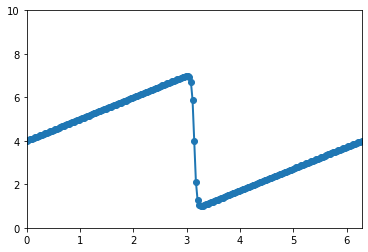

In [77]:
u = np.asarray([ufunc(t, x0, nu) for x0 in x])
plt.figure()
plt.plot(x, u, marker='o', lw=2)
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10]);

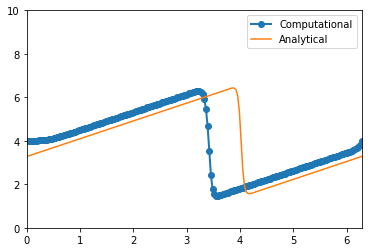

In [78]:
nx = 201
nt = 100
dx = 2 * np.pi / (nx - 1)
nu = .07
dt = dx * nu

x = np.linspace(0, 2 * np.pi, nx)
un = np.empty(nx)
t = 0

solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu)

# Analytical solution
u_analytical = np.asarray([ufunc(nt * dt, xi, nu) for xi in x])


#Plotting data
plt.figure()
plt.plot(x,u, marker='o', lw=2, label='Computational')
plt.plot(x, u_analytical, label='Analytical')
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10])
plt.legend();

$\textbf{The computed values are almost equivalent to analytical ones.}$

## $\textbf{Call Funtions}$

### $\textbf{Pure function}$

In [86]:
%timeit solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu)

211 ms ± 3.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### $\textbf{Function with numba accelerator}$

In [87]:
%timeit solve_1d_burger_numba(u, un, nt, nx, dt, dx, nu)

195 µs ± 5.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### $\textbf{Function with pyccel accelerator}$

In [88]:
solve_1d_burger_f90 = epyccel(solve_1d_burger_pyccel)

In [89]:
%timeit solve_1d_burger_f90(u, un, nt, nx, dt, dx, nu)

422 µs ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


$\textbf{Pyccel implementation runs faster than pure function implementation. Numba accelerator does better than both.}$